In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
from pandas.tseries.offsets import BDay
from sklearn.externals import joblib
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

### Time Series Exploration
Functions for checking stationarity (constant mean, constant variance and autocorrelation that does not depend on time) and for plotting ACF (autocorrelation function) and PACF (partial autocorrelation function)

In [117]:
def test_stationarity(timeseries):
    """Check stationarity of time series by visualizing the rolling mean and standard deviation. 
    Performs Dickey-Fuller Test."""
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=20).mean()
    rolstd = timeseries.rolling(window=20).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    # Notes on Dickey-Fuller Test :
    #Here the null hypothesis is that the TS is non-stationary. 
    #The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. 
    #If the ‘Test Statistic’ < ‘Critical Value’, we can reject the null hypothesis and 
    # say that the series is stationary. 
    from statsmodels.tsa.stattools import adfuller
    
    print('Results of Augmented Dickey-Fuller test:')
    dftest = adfuller(timeseries['y'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value ({})'.format(key)] = value
    print(dfoutput)

In [118]:
def acf_pcf_plots(timeseries):
    """Generate ACF and PCF plots"""
    
    from statsmodels.tsa.stattools import acf, pacf
    lag_acf = acf(timeseries, nlags=30)
    lag_pacf = pacf(timeseries, nlags=30, method='ols')
    
    #Plot ACF: 
    plt.subplot(121) 
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')
    
    #Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()

### Time Series Modelling

In [119]:
def pre_process_prophet(df):
    """Pre-process input df to format accepted by Prophet. Here we will only forecast closing prices."""
    
    #Convert Date type to datettime
    df['Date']= pd.to_datetime(df['Date'],infer_datetime_format=True)
    # Only pick closing price
    df= df[['Date','Close']]
    # Renaming column (required for passing to Prophet)
    df.columns = ['ds','y']
    
    return df

In [5]:
def create_simple_train_test(df_processed,step):
    """Create train and test set after processing dataframe.
    Take points with fixed interval (step) from beginning to end of dataframe as test set and 
    the remaining as training set."""
    
    # create test set with stepsize 'step' from beginning to end
    df_test = df_processed.iloc[range(0,len(df_processed)+1,step),:]
    
    # set the remaining points as training set
    index = ~(df_processed['ds'].isin(df_test['ds']))
    df_train = df_processed.loc[index]
    
    return df_test, df_train

In [6]:
def fit_prophet_train_test(df_train,df_test,changepoint_range, changepoint_prior_scale):
    """Create a Prophet Model with specified parameters changepoint_range & changepoint_prior_scale.
    Fit the training set and evaluate performance on testing set."""
    
    # create Prophet model
    model = Prophet(changepoint_range=changepoint_range, changepoint_prior_scale=changepoint_prior_scale)
    model.fit(df_train)
    
    # Get test dates 
    test_dates = df_test[['ds']]
    
    # Fit the model to test dates
    predicted = model.predict(test_dates)
    
    plt.figure(figsize=[10,5])
    plt.plot(df_test['ds'], df_test['y'], color='r', label='actual test values')
    plt.plot(predicted['ds'],predicted['yhat'], color='g', label='predicted test values')
    plt.legend(loc='best')
    
    return model,predicted

In [17]:
def get_forecast(model, n_days):
    """Generate forecasts for specified number of days in the future."""
    
    # Make a dataframe with a column ds containing the dates for which a prediction is to be made
    future = model.make_future_dataframe(periods=n_days)
    
    # Filter only for business days (weekdays)
    isBusinessDay = BDay().onOffset
    weekdays = future['ds'].map(isBusinessDay)
    future = future[weekdays]
    
    # Make forecast
    forecast = model.predict(future)
    
    return forecast

In [8]:
def plot_forecasted_cv(df_cv, cutoff_date):
    """Generate plot of actual values vs forecasted values obtained from df_cv. 
    df_cv is dataframe containing prediction results from cross_validation function in Prophet package."""
    
    current_horizon = df_cv[df_cv['cutoff']==cutoff_date]
    plt.plot(current_horizon['ds'], current_horizon['y'], color='r', label='actual values')
    plt.plot(current_horizon['ds'], current_horizon['yhat'], color='g', label='forecasted values')
    plt.legend(loc='best')

In [9]:
def plot_cross_validation_metric(df_cv, metric, rolling_window=0.1, ax=None):
    """Plot a performance metric vs. forecast horizon from cross validation.
    Cross validation produces a collection of out-of-sample model predictions
    that can be compared to actual values, at a range of different horizons
    (distance from the cutoff). This computes a specified performance metric
    for each prediction, and aggregated over a rolling window with horizon.
    This uses fbprophet.diagnostics.performance_metrics to compute the metrics.
    Valid values of metric are 'mse', 'rmse', 'mae', 'mape', and 'coverage'.
    rolling_window is the proportion of data included in the rolling window of
    aggregation. The default value of 0.1 means 10% of data are included in the
    aggregation for computing the metric.
    As a concrete example, if metric='mse', then this plot will show the
    squared error for each cross validation prediction, along with the MSE
    averaged over rolling windows of 10% of the data.
    Parameters
    ----------
    df_cv: The output from fbprophet.diagnostics.cross_validation.
    metric: Metric name, one of ['mse', 'rmse', 'mae', 'mape', 'coverage'].
    rolling_window: Proportion of data to use for rolling average of metric.
        In [0, 1]. Defaults to 0.1.
    ax: Optional matplotlib axis on which to plot. If not given, a new figure
        will be created.
    Returns
    -------
    a matplotlib figure.
    """
    if ax is None:
        fig = plt.figure(facecolor='w', figsize=(10, 6))
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
    # Get the metric at the level of individual predictions, and with the rolling window.
    df_none = performance_metrics(df_cv, metrics=[metric], rolling_window=0)
    df_h = performance_metrics(df_cv, metrics=[metric], rolling_window=rolling_window)

    # Some work because matplotlib does not handle timedelta
    # Target ~10 ticks.
    tick_w = max(df_none['horizon'].astype('timedelta64[ns]')) / 10.
    # Find the largest time resolution that has <1 unit per bin.
    dts = ['D', 'h', 'm', 's', 'ms', 'us', 'ns']
    dt_names = [
        'days', 'hours', 'minutes', 'seconds', 'milliseconds', 'microseconds',
        'nanoseconds'
    ]
    dt_conversions = [
        24 * 60 * 60 * 10 ** 9,
        60 * 60 * 10 ** 9,
        60 * 10 ** 9,
        10 ** 9,
        10 ** 6,
        10 ** 3,
        1.,
    ]
    for i, dt in enumerate(dts):
        if np.timedelta64(1, dt) < np.timedelta64(tick_w, 'ns'):
            break

    x_plt = df_none['horizon'].astype(np.int64) / float(dt_conversions[i])
    x_plt_h = df_h['horizon'].astype(np.int64) / float(dt_conversions[i])

    ax.plot(x_plt, df_none[metric], '.', alpha=0.5, c='gray')
    ax.plot(x_plt_h, df_h[metric], '-', c='b')
    ax.grid(True)

    ax.set_xlabel('Horizon ({})'.format(dt_names[i]))
    ax.set_ylabel(metric)
    return fig

## Forecasting FTSE ST Industrials Index

In [10]:
df_FTSE_indu = pd.read_csv('FTSE ST Industrials Index.csv')
df_FTSE_indu = pre_process_prophet(df_FTSE_indu)

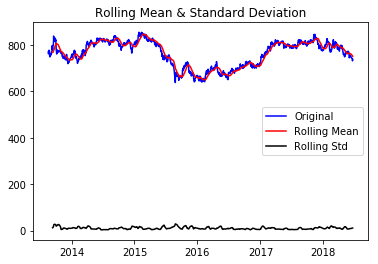

Results of Augmented Dickey-Fuller test:
test statistic            -2.014656
p-value                    0.280184
# of lags                  0.000000
# of observations       1228.000000
Critical Value (1%)       -3.435686
Critical Value (5%)       -2.863896
Critical Value (10%)      -2.568025
dtype: float64


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [11]:
test_stationarity(df_FTSE_indu.set_index('ds'))

Since t-stats is greater than the critical values, we do not reject Ho. Thus the series is non stationary.

In [12]:
df_test_FTSE_indu,df_train_FTSE_indu = create_simple_train_test(df_FTSE_indu,10)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\user\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


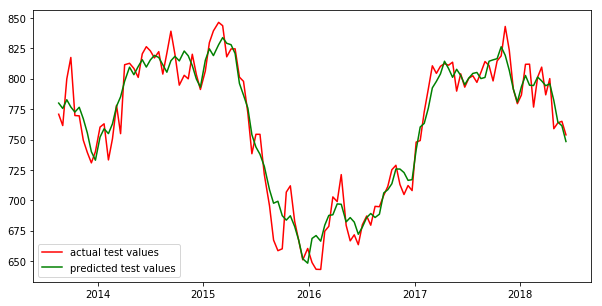

In [13]:
FTSE_indu_model, FTSE_indu_predicted = fit_prophet_train_test(df_train_FTSE_indu,df_test_FTSE_indu,0.9, 0.03)

By taking steps of 10 for the test set and setting the remaining points as training set, the model can predict trends in the test set well.

In [18]:
# Save Prophet model
model_FTSE_indu = Prophet(changepoint_range=0.9, changepoint_prior_scale= 0.03)
joblib.dump(model_FTSE_indu, 'FTSE_Indu_Model.pkl') 

['FTSE_Indu_Model.pkl']

### Getting Forecasts

In [19]:
forecast_FTSE_indu = get_forecast(FTSE_indu_model,365)
forecast_FTSE_indu[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1362,2019-06-14,583.127177,472.853487,706.661222
1363,2019-06-17,578.908036,463.161410,703.776190
1364,2019-06-18,578.477800,460.324949,706.299842
1365,2019-06-19,576.683910,457.313242,703.214263
1366,2019-06-20,575.197596,459.692263,704.933026


In [20]:
#forecast_FTSE_indu.to_csv('FTSE Industrials Forecast.csv', index=False)

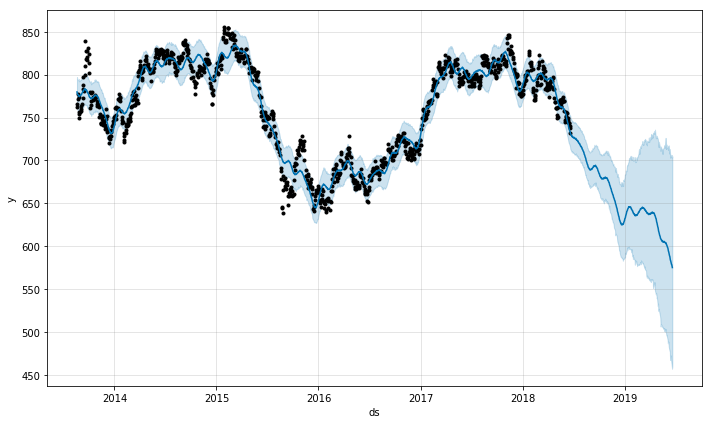

In [21]:
fig_FTSE_indu =FTSE_indu_model.plot(forecast_FTSE_indu)

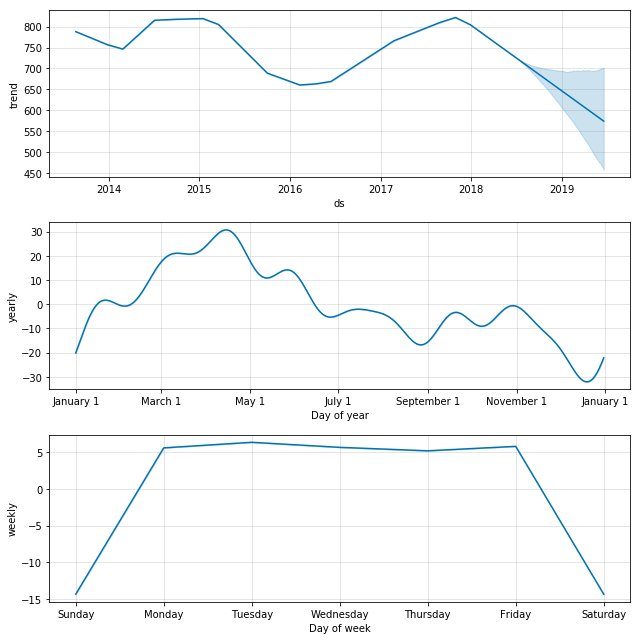

In [22]:
FTSE_indu_components = FTSE_indu_model.plot_components(forecast_FTSE_indu)

### Cross-Validation with Multiple Cut-Off Points
Cross validation to measure forecast error using historical data. 
This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. Then compare the forecasted values to the actual values. 

INFO:fbprophet.diagnostics:Making 16 forecasts with cutoffs between 2014-07-11 00:00:00 and 2018-03-22 00:00:00
C:\Users\user\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


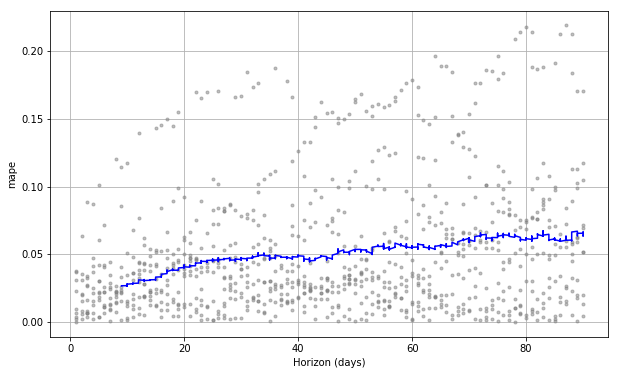

In [25]:
df_cv_FTSE_indu = cross_validation(FTSE_indu_model,period ='90 days',horizon = '90 days')
df_p_FTSE_ind = performance_metrics(df_cv_FTSE_indu)
fig_cv_FTSE_indu = plot_cross_validation_metric(df_cv_FTSE_indu, metric='mape')

MAPE (Mean absolute percentage error) of around 2% are typical for 10 days horizon, 4% for 30 days horizon and 6% for 90 days horizon

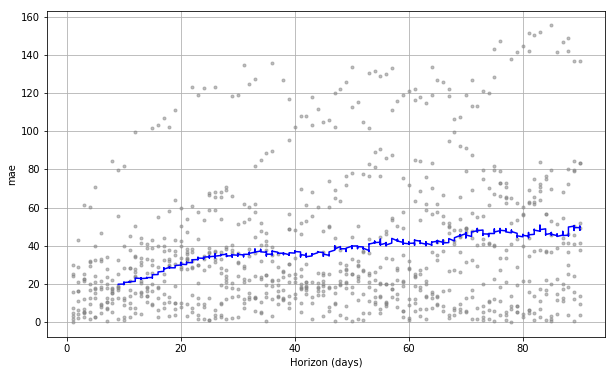

In [26]:
fig_cv_FTSE_indu_2 = plot_cross_validation_metric(df_cv_FTSE_indu, metric='mae')

MAE (mean absolute error) of 20 are typical for 10 days horizon, increasing up to 48 for 90 days horizon.

In [27]:
df_p_FTSE_ind.head()

,horizon,mse,rmse,mae,mape,coverage
170,9 days,672.137492,25.925615,19.734013,0.026717,0.488889
616,9 days,673.598818,25.953782,19.818835,0.026812,0.488889
617,10 days,674.514043,25.971408,19.866631,0.026862,0.488889
732,10 days,667.988482,25.845473,19.623823,0.026487,0.500000
790,10 days,682.654178,26.127652,19.888910,0.026795,0.488889


In [28]:
df_p_FTSE_ind.tail()

,horizon,mse,rmse,mae,mape,coverage
109,90 days,4181.894384,64.667568,48.891637,0.064705,0.333333
495,90 days,4216.264993,64.932773,49.127781,0.065162,0.333333
384,90 days,4019.310949,63.398036,48.098940,0.063575,0.333333
219,90 days,4044.274751,63.594613,48.439828,0.064012,0.333333
900,90 days,4038.815923,63.551679,48.373143,0.063970,0.333333


## Forecasting FTSE ST Consumer Goods & Services Index

In [36]:
df_FTSE_cgs = pd.read_csv('FTSE ST Consumer Goods & Services Index.csv')
df_FTSE_cgs = pre_process_prophet(df_FTSE_cgs)

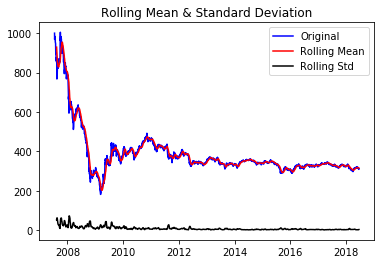

Results of Augmented Dickey-Fuller test:
test statistic            -3.679103
p-value                    0.004417
# of lags                 28.000000
# of observations       2815.000000
Critical Value (1%)       -3.432675
Critical Value (5%)       -2.862567
Critical Value (10%)      -2.567317
dtype: float64


In [38]:
test_stationarity(df_FTSE_cgs.set_index('ds'))

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\user\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


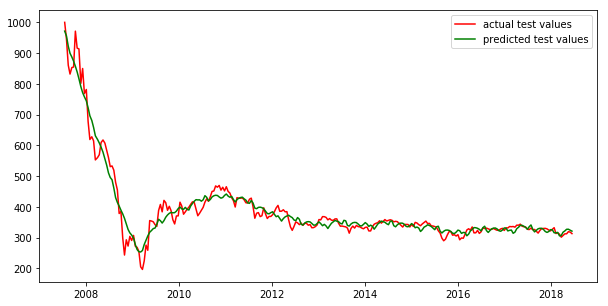

In [104]:
df_test_FTSE_cgs,df_train_FTSE_cgs = create_simple_train_test(df_FTSE_cgs,10)
FTSE_cgs_model, FTSE_cgs_predicted = fit_prophet_train_test(df_train_FTSE_cgs,df_test_FTSE_cgs,0.9, 0.03)

The model can predict trends in the test set well although not capturing all volatility.

In [105]:
# Save Prophet model
model_FTSE_cgs = Prophet(changepoint_range=0.9, changepoint_prior_scale= 0.03)
joblib.dump(model_FTSE_cgs, 'FTSE_CGS_Model.pkl') 

['FTSE_CGS_Model.pkl']

### Getting Forecasts

In [106]:
forecast_FTSE_cgs = get_forecast(FTSE_cgs_model,365)
forecast_FTSE_cgs[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2815,2019-06-14,308.879361,233.658715,379.578833
2816,2019-06-17,306.726080,230.522517,374.922227
2817,2019-06-18,305.665684,225.723773,371.812498
2818,2019-06-19,305.477253,225.978801,373.237555
2819,2019-06-20,305.330808,229.307118,377.466833


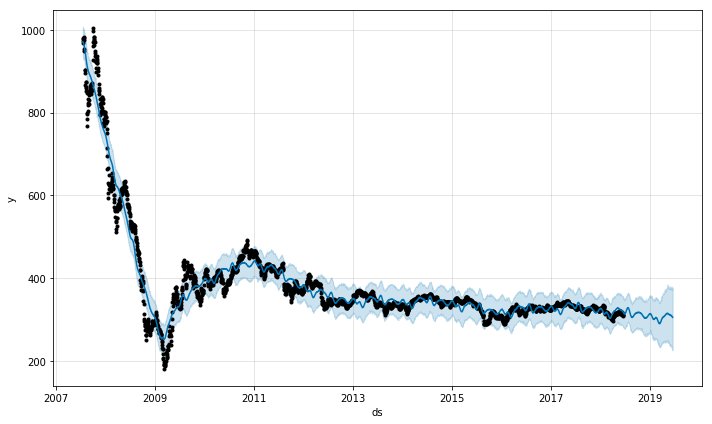

In [107]:
fig_FTSE_cgs =FTSE_cgs_model.plot(forecast_FTSE_cgs)

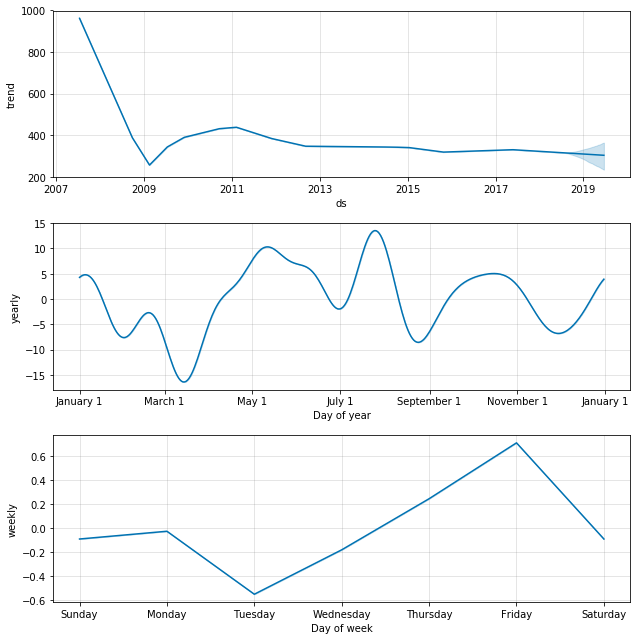

In [108]:
FTSE_cgs_components = FTSE_cgs_model.plot_components(forecast_FTSE_cgs)

### Cross-Validation with Multiple Cut-Off Points
Cross validation to measure forecast error using historical data. 
This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. Then compare the forecasted values to the actual values. 

In [109]:
df_cv_FTSE_cgs = cross_validation(FTSE_cgs_model,period ='90 days',horizon = '90 days')

INFO:fbprophet.diagnostics:Making 41 forecasts with cutoffs between 2008-05-13 00:00:00 and 2018-03-22 00:00:00
C:\Users\user\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [110]:
df_p_FTSE_cgs = performance_metrics(df_cv_FTSE_cgs)

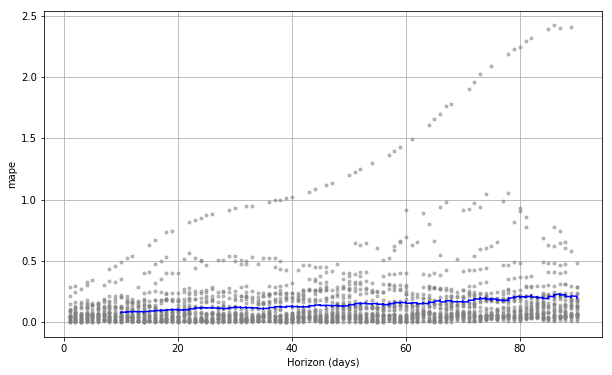

In [111]:
fig_cv_FTSE_cgs_2= plot_cross_validation_metric(df_cv_FTSE_cgs, metric='mape')

MAPE (Mean absolute percentage error) of around 7% are typical for 10 days horizon and 20% for 90 days horizon

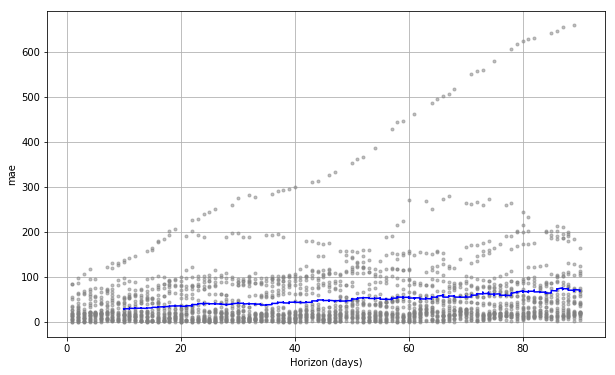

In [112]:
fig_cv_FTSE_cgs= plot_cross_validation_metric(df_cv_FTSE_cgs, metric='mae')

MAE (mean absolute error) of 28 are typical for 10 days horizon, increasing up to 68 for 90 days horizon.

In [113]:
df_p_FTSE_cgs.head()

,horizon,mse,rmse,mae,mape,coverage
2029,10 days,1567.647161,39.593524,28.079793,0.076547,0.784810
2144,10 days,1568.124161,39.599547,28.121405,0.076679,0.784810
1277,10 days,1565.088690,39.561202,28.012178,0.076426,0.784810
409,10 days,1565.958037,39.572188,28.058968,0.076541,0.784810
582,10 days,1605.756759,40.071895,28.401644,0.077176,0.780591


In [114]:
df_p_FTSE_cgs.tail()

,horizon,mse,rmse,mae,mape,coverage
56,90 days,14559.772226,120.663881,68.496604,0.198927,0.531646
692,90 days,14562.717848,120.676086,68.521844,0.198994,0.531646
1674,90 days,14563.398707,120.678907,68.544393,0.199053,0.531646
1617,90 days,14501.046328,120.420290,68.069823,0.197937,0.535865
2369,90 days,14502.499077,120.426322,68.113241,0.198079,0.535865


## Forecasting FTSE ST Technology Index

In [ ]:
df_FTSE_tech = pd.read_csv('FTSE ST Technology Index.csv')
df_FTSE_tech = pre_process_prophet(df_FTSE_tech)

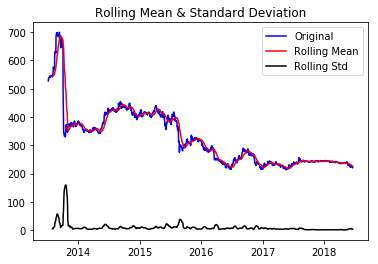

Results of Augmented Dickey-Fuller test:
test statistic            -2.531373
p-value                    0.108026
# of lags                 17.000000
# of observations       1239.000000
Critical Value (1%)       -3.435639
Critical Value (5%)       -2.863876
Critical Value (10%)      -2.568013
dtype: float64


In [40]:
test_stationarity(df_FTSE_tech.set_index('ds'))

t-stats > critical values, hence we do not reject Ho, the series is not stationary.

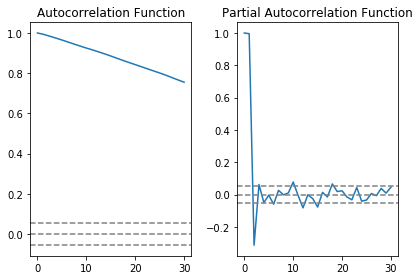

In [41]:
acf_pcf_plots(df_FTSE_tech.set_index('ds'))

In [42]:
def fit_prophet_train_test_tech(df_train,df_test,changepoint_range, changepoint_prior_scale):
    """Create a Prophet Model with specified parameters changepoint_range & changepoint_prior_scale.
    Fit the training set and evaluate performance on testing set."""
    
    # create Prophet model
    model = Prophet(changepoint_range=changepoint_range, changepoint_prior_scale=changepoint_prior_scale,
                    seasonality_prior_scale=0.005)
    model.fit(df_train)
    
    # Get test dates 
    test_dates = df_test[['ds']]
    
    # Fit the model to test dates
    predicted = model.predict(test_dates)
    
    plt.figure(figsize=[10,5])
    plt.plot(df_test['ds'], df_test['y'], color='r', label='actual test values')
    plt.plot(predicted['ds'],predicted['yhat'], color='g', label='predicted test values')
    plt.legend(loc='best')
    
    return model,predicted

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\godeliva.marisu\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


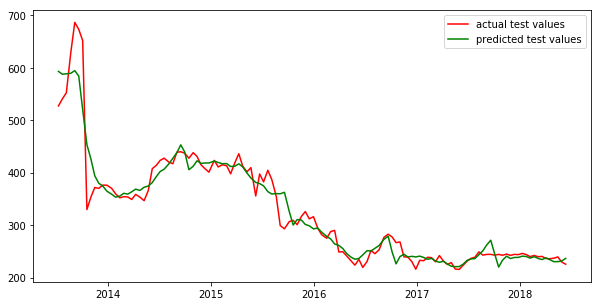

In [43]:
df_test_FTSE_tech,df_train_FTSE_tech = create_simple_train_test(df_FTSE_tech,10)
FTSE_tech_model, FTSE_tech_predicted = fit_prophet_train_test_tech(df_train_FTSE_tech,df_test_FTSE_tech,0.9, 0.08)

In [44]:
from sklearn.metrics import mean_squared_error
print('MSE: ',mean_squared_error(df_test_FTSE_tech['y'],FTSE_tech_predicted['yhat']))

MSE:  748.7433031585517


In [45]:
from sklearn.metrics import mean_absolute_error
print('MAE: ',mean_absolute_error(df_test_FTSE_tech['y'],FTSE_tech_predicted['yhat']))

MAE:  16.073425197710225


In [29]:
# Save Prophet model
model_FTSE_tech = Prophet(changepoint_range=0.9, changepoint_prior_scale= 0.08)
joblib.dump(model_FTSE_tech, 'FTSE_Tech_Model.pkl') 

['FTSE_Tech_Model.pkl']

### Getting Forecasts

In [46]:
forecast_FTSE_tech = get_forecast(FTSE_tech_model,365)
forecast_FTSE_tech[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1491,2019-06-16,253.373844,39.502916,475.139422
1492,2019-06-17,253.903252,46.281524,474.048242
1493,2019-06-18,253.868059,35.991836,476.998298
1494,2019-06-19,253.584563,34.449892,478.274152
1495,2019-06-20,257.958875,42.730150,476.568646


In [48]:
forecast_FTSE_tech.to_csv('FTSE Technology Forecast.csv', index=False)

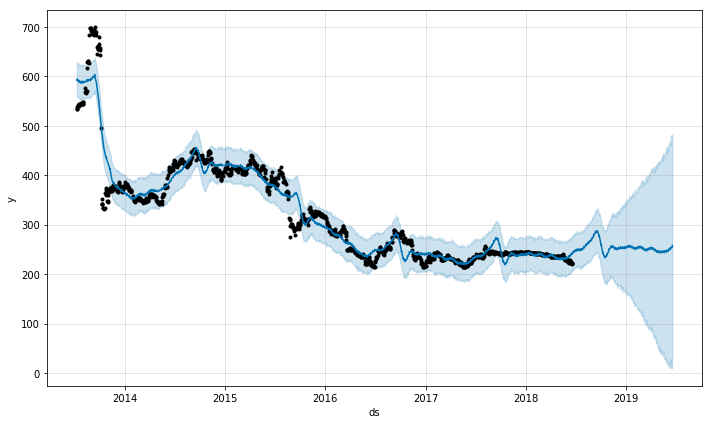

In [80]:
fig_FTSE_tech =FTSE_tech_model.plot(forecast_FTSE_tech)

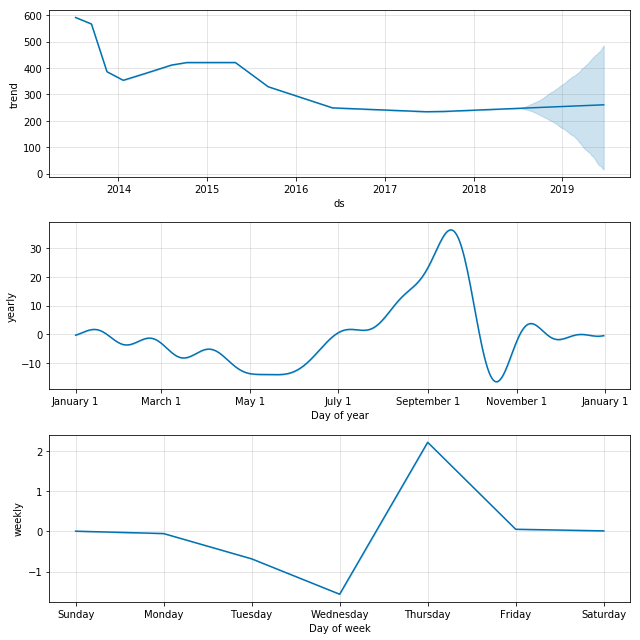

In [81]:
FTSE_tech_components = FTSE_tech_model.plot_components(forecast_FTSE_tech)

### Cross-Validation with Multiple Cut-Off Points
Cross validation to measure forecast error using historical data. 
This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. Then compare the forecasted values to the actual values. 

INFO:fbprophet.diagnostics:Making 17 forecasts with cutoffs between 2014-04-12 00:00:00 and 2018-03-22 00:00:00
C:\Users\godeliva.marisu\AppData\Local\Continuum\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


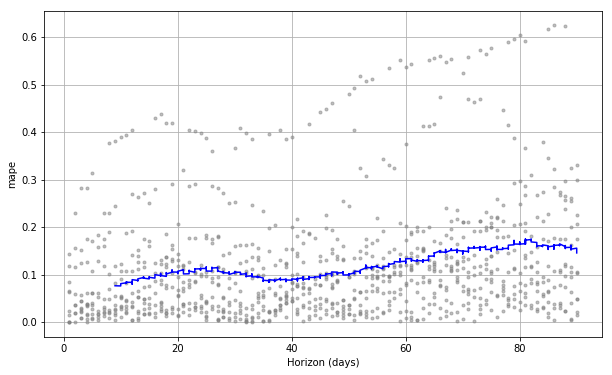

In [82]:
df_cv_FTSE_tech = cross_validation(FTSE_tech_model,period ='90 days',horizon = '90 days')
df_p_FTSE_tech = performance_metrics(df_cv_FTSE_tech)
fig_cv_FTSE_tech = plot_cross_validation_metric(df_cv_FTSE_tech, metric='mape')

MAPE (Mean absolute percentage error) of around 7% are typical for 10 days horizon and 15% for 90 days horizon

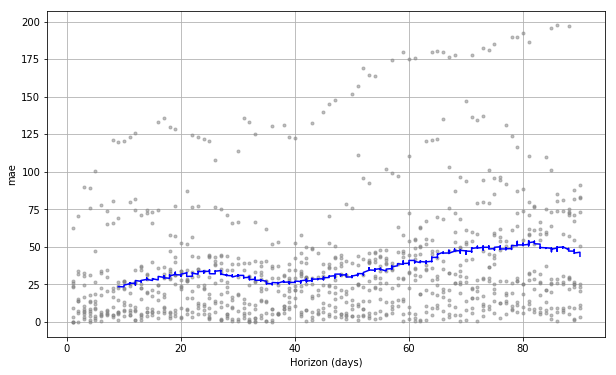

In [83]:
fig_cv_FTSE_tech_2 = plot_cross_validation_metric(df_cv_FTSE_tech, metric='mae')

MAE (mean absolute error) of 24 are typical for 10 days horizon, increasing up to 44 for 90 days horizon.

In [84]:
df_p_FTSE_tech.head()

,horizon,mse,rmse,mae,mape,coverage
335,9 days,1318.246798,36.307669,23.583456,0.076311,0.842105
846,10 days,1312.644307,36.230433,23.407407,0.075951,0.842105
731,10 days,1314.468334,36.255597,23.545773,0.076524,0.842105
391,10 days,1316.178514,36.279175,23.580046,0.076576,0.842105
673,10 days,1316.844692,36.288355,23.663071,0.076935,0.842105


In [85]:
df_p_FTSE_tech.tail()

,horizon,mse,rmse,mae,mape,coverage
220,90 days,3935.124546,62.730571,45.914815,0.151599,0.747368
841,90 days,3874.488299,62.245388,45.336951,0.150672,0.747368
55,90 days,3565.377067,59.710778,44.147576,0.146290,0.757895
551,90 days,3508.824851,59.235334,43.855895,0.145577,0.757895
956,90 days,3506.118508,59.212486,43.803206,0.145463,0.757895
